_Note: To execute code in this repository, you will need to install the `niwaves` package from GitHub:_

https://github.com/rciric/niwaves

# Exploring alternative thresholds for subject discriminability

#### Rastko Ciric<sup>1</sup>

<sup>1</sup>, Department of Bioengineering, Stanford University

We previously saw evidence of subject discriminability using lag systems; however, this discriminability was reflected in extremely weak correlations (< 0.1) between each subject's session-level lag estimates. In this short notebook, we'll investigate whether it might be possible to increase these correlations by applying a threshold to the lag matrix. It's possible that lags corresponding to stronger connections are generally more reliable measures, and restricting our analysis to these correlations might bring us closer to our objective of identifying subjects on the basis of their lag systems. To that end, we'll vary a threshold on the basis of 

In [1]:
import glob
import niwaves
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

We begin, as before, by loading the subject data and performing lag analysis in `niwaves`.

In [2]:
subjects = ['sub-MSC{:02}'.format(i) for i in range(1,11)]
sessions = ['ses-func{:02}'.format(i) for i in range(1,11)]
tasks = ['task-rest',
         'task-motor',
         'task-memory*',
         'task-glasslexical']
runs = ['run-01']
ts = {
      task: {
       sub: {
        ses: {
         run: {'roi': glob.glob('data/MSC/ts/{}_{}_{}_run-*_schaefer400_ts.1D'.format(sub, ses, task)),
          'motion': glob.glob('data/MSC/motion/{}_{}_{}_run-*_relRMS.1D'.format(sub, ses, task))
         } for run in runs
        } for ses in sessions
       } for sub in subjects
      } for task in tasks
     }

In [3]:
community = pd.read_table('data/network/schaefer400x7CommunityAffiliation.1D', header=None)

In [4]:
# Rest: session level.
ts_rest = {}
ts_motion = {}
lags_rest = {}
peaks_rest = {}
tmask_rest = {}
for sub in subjects:
    lags_rest[sub] = {}
    peaks_rest[sub] = {}
    tmask_rest[sub] = {}
    for ses in sessions:
        ts_rest[ses] = pd.read_csv(ts['task-rest'][sub][ses]['run-01']['roi'][0],
                                   sep=' ', header=None)
        ts_motion[ses] = pd.read_csv(ts['task-rest'][sub][ses]['run-01']['motion'][0],
                                     sep=' ', header=None)
        tmask_rest[sub][ses] = ts_motion[ses] < 0.2
        lags_rest[sub][ses], peaks_rest[sub][ses] = niwaves.lag_analysis(timeseries1=ts_rest[ses].values,
                                                                         tmask=tmask_rest[sub][ses].values,
                                                                         sample_time=2.2,
                                                                         min_block=10,
                                                                         lagmax=3)

Now, let's examine the _peak_ matrix. Lag analysis yields two outputs: a lag matrix, on which our previous examination has been concentrated, and a peak matrix.

* The lag matrix contains the latencies between each pair of nodes. It corresponds to the abscissa of the vertex of the parabola fit to the optimum during the lag interpolation step.
* The peak matrix contains the peak correlation between each pair of nodes across all time shifts. It corresponds to the ordinate of the vertex of the parabola fit to the optimum during the lag interpolation step.

Below, we generate the peak matrix and plot it in the same way we've previously plotted the lag matrix, sorted by community and plotted so that the colourmap spans from _r = -0.55_ to _r = 0.55_. Note the zero-centred distribution, reflective of the inclusion of global signal regression in the 36-parameter denoising model. (Also note that, because we're hijacking the sort-and-plot function from `niwaves`, the abscissa of the distribution plot is mislabelled as "Time" instead of "Correlation".)

(In order to compute the correlation between subject-specific lag systems, we need to select the same features across all subjects. Because of this, we have to apply the threshold to the group average peak matrix.)

/home/vagrant/miniconda3/envs/py3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


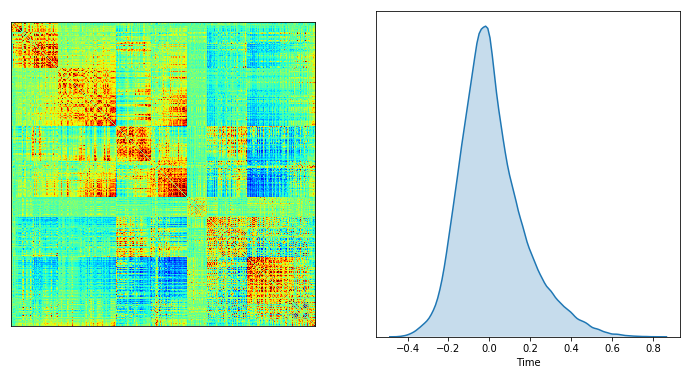

In [5]:
# Aggregate all matrices
group = np.zeros([len(subjects)*len(sessions), len(community), len(community)])
for i, sub in enumerate(subjects):
    for j, ses in enumerate(sessions):
        group[i*len(sessions)+j,:,:] = peaks_rest[sub][ses]

# Compute the average matrix across the sample
groupmean = np.nanmean(group, axis=0).squeeze()
groupmean[np.diag_indices_from(groupmean)] = 0
niwaves.lag_sort(groupmean, community=community, vrange=[-0.55, 0.55])
groupmean = np.abs(groupmean)

Next, let's write a quick function that estimates "subject-specificity" of lag. "Subject-specificity" here is rather crudely defined as the mean correlation between lag matrix features of the same subject divided by the mean correlation between lag matrix features of different subjects. The function also accepts a percentile threshold as an argument; it applies this threshold to the peak matrix computed above in order to extract lag features corresponding to the strongest functional connections from each subject's lag matrix. We then iterate over integer threshold values from 0 to 99 and compute the "subject-specificity" of the selected lag features. (This operation is _slow_, so I've added a reporter that prints as it steps through each threshold.)

When we wrap up, we plot "subject-specificity" by threshold.

0 . . . 1 . . . 2 . . . 3 . . . 4 . . . 5 . . . 6 . . . 7 . . . 8 . . . 9 . . . 10 . . . 11 . . . 12 . . . 13 . . . 14 . . . 15 . . . 16 . . . 17 . . . 18 . . . 19 . . . 20 . . . 21 . . . 22 . . . 23 . . . 24 . . . 25 . . . 26 . . . 27 . . . 28 . . . 29 . . . 30 . . . 31 . . . 32 . . . 33 . . . 34 . . . 35 . . . 36 . . . 37 . . . 38 . . . 39 . . . 40 . . . 41 . . . 42 . . . 43 . . . 44 . . . 45 . . . 46 . . . 47 . . . 48 . . . 49 . . . 50 . . . 51 . . . 52 . . . 53 . . . 54 . . . 55 . . . 56 . . . 57 . . . 58 . . . 59 . . . 60 . . . 61 . . . 62 . . . 63 . . . 64 . . . 65 . . . 66 . . . 67 . . . 68 . . . 69 . . . 70 . . . 71 . . . 72 . . . 73 . . . 74 . . . 75 . . . 76 . . . 77 . . . 78 . . . 79 . . . 80 . . . 81 . . . 82 . . . 83 . . . 84 . . . 85 . . . 86 . . . 87 . . . 88 . . . 89 . . . 90 . . . 91 . . . 92 . . . 93 . . . 94 . . . 95 . . . 96 . . . 97 . . . 98 . . . 99 . . . 

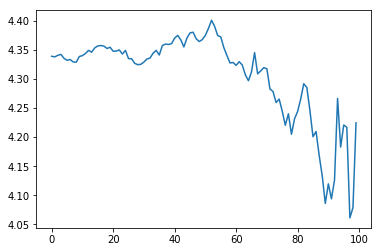

In [6]:
def subject_specificity(pct_thr, groupmean, lags):

    # Identify edges associated with superthreshold values
    thresh = np.percentile(groupmean[np.triu_indices_from(groupmean)], pct_thr)
    idx = np.where(groupmean[np.triu_indices_from(groupmean)] > thresh)[0]

    # Compute the session-wise correlation matrix
    groupr = lags.iloc[idx]
    groupcorr = groupr.corr()
    #plt.imshow(groupcorr,
    #           vmin=0.01,
    #           vmax=0.08)

    # Within vs. between
    groupcorr.values[np.diag_indices_from(groupcorr)] = 0
    subkey = np.array([i for i in range(1,11) for k in range(10)], ndmin=2)
    within = (subkey == subkey.T)
    between = np.logical_not(within)
    within[np.diag_indices_from(within)] = 0
    return np.mean(groupcorr.values[within]), np.mean(groupcorr.values[between])

# Aggregate all lags associated with strong connections
groupr = {}
for i, sub in enumerate(subjects):
    for j, ses in enumerate(sessions):
        groupr[(sub, ses)] = lags_rest[sub][ses].ravel()
groupr = pd.DataFrame(groupr)

specs = range(100)
specificity = np.zeros(100)

for spec in specs:
    print('{} . . . '.format(spec), end='')
    within, between = subject_specificity(spec, groupmean, groupr)
    specificity[spec] = within/between
    
plt.plot(specificity)

It appears that "subject-specificity" initially exhibits a slow increase as the threshold is tuned upward before reaching a maximum, descending steeply, and entering a high-noise region for stringent threshold values. Let's repeat the inter-session similarity analysis from before, this time considering only lags that satisfy the threshold that maximises "subject-specificity".

In [7]:
maxspec = np.where(specificity==max(specificity))[0][0]
print('Maximum specificity at threshold {}'.format(maxspec))
# Identify edges associated with superthreshold values
thresh = np.percentile(groupmean[np.triu_indices_from(groupmean)], maxspec)
idx = np.where(groupmean[np.triu_indices_from(groupmean)] > thresh)[0]

# Compute the session-wise correlation matrix
lags = groupr.iloc[idx]

Maximum specificity at threshold 52


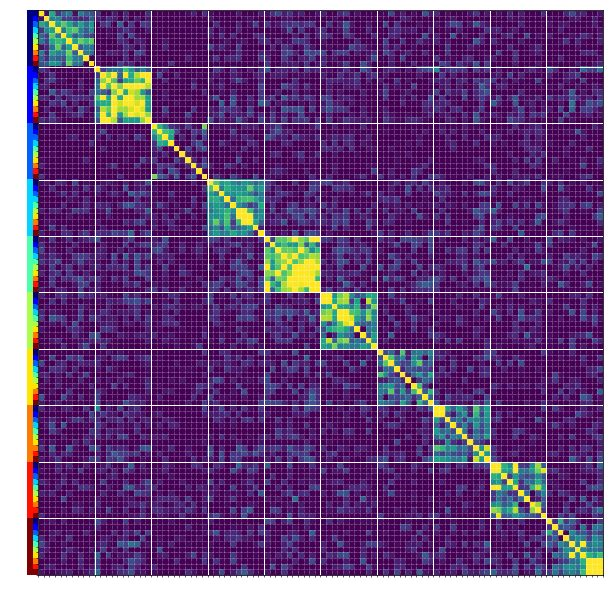

In [9]:
niwaves.simil_plot(simil=lags.corr(), within=10, vrange=[0.01, 0.08])

Unfortunately, our results haven't much improved over the zero-threshold case.